# Reservoir of Izhikevich neuron models

In this script a reservoir of neurons models with the differential equations proposed by Izhikevich is defined. 

In [14]:
%matplotlib inline
import pyNN.nest as p
from pyNN.random import NumpyRNG, RandomDistribution
from pyNN.utility import Timer
import matplotlib.pyplot as plt
import numpy as np

timer = Timer()
p.setup(timestep=0.1) # 0.1ms 

0

## Definition of Inputs

The input can be:
- the joint position of the robot arm (rate coded or temporal coded)

In [15]:
poisson_input = p.SpikeSourcePoisson(rate = 10, start = 20.)
#input_neuron = p.Population(2, p.SpikeSourcePoisson, {'rate': 0.7}, label='input')
input_neuron = p.Population(2, poisson_input, label='input')

## Definition of neural populations

Izhikevich spiking model with a quadratic non-linearity: 

dv/dt = 0.04*v^2 + 5*v + 140 - u + I 

du/dt = a*(b*v - u)

In [16]:
n = 1500          # number of cells
exc_ratio = 0.8   # ratio of excitatory neurons

n_exc = int(round(n*0.8))
n_inh = n-n_exc
print n_exc, n_inh


celltype = p.Izhikevich()
#celltype = p.IF_cond_exp()
print celltype.get_parameter_names
exc_cells = p.Population(n_exc, celltype, label="Excitatory_Cells")
inh_cells = p.Population(n_inh, celltype, label="Inhibitory_Cells")

# initialize with a uniform random distributin
# use seeding for reproducability
rngseed = 98766987
parallel_safe = True

rng = NumpyRNG(seed=rngseed, parallel_safe=parallel_safe)

unifDistr = RandomDistribution('uniform', (-75,-65), rng=rng)
exc_cells.initialize(v=unifDistr)
inh_cells.initialize(v=unifDistr)

1200 300
<bound method type.get_parameter_names of <class 'pyNN.nest.standardmodels.cells.Izhikevich'>>


## Definition of readout neurons

Decide:
- 2 readout neurons: representing the desired displacement of the two motors
- 1 readout neuron: representing the desired goal position of the joint

In [17]:
readout_neurons = p.Population(2, celltype, label="readout_neuron")

## Define the connections between the neurons

In [18]:
res_pconn = 0.01      # sparse connection probability
input_pconn= 0.2

input_conn = p.FixedProbabilityConnector(input_pconn, rng=rng)
rout_conn = p.AllToAllConnector()

exc_conn = p.FixedProbabilityConnector(res_pconn, rng=rng)
inh_conn = p.FixedProbabilityConnector(res_pconn, rng=rng)


w_exc = 20.   # later add unit
w_inh = 51.   # later add unit
w_input = 70.
delay_exc = 1      # defines how long (ms) the synapse takes for transmission
delay_inh = 1

stat_syn_exc = p.StaticSynapse(weight =w_exc, delay=delay_exc)
stat_syn_inh = p.StaticSynapse(weight =w_inh, delay=delay_inh)


weight_distr_input = RandomDistribution('normal', [w_input, 1e-3], rng=rng)

weight_distr_exc = RandomDistribution('normal', [w_exc, 1e-3], rng=rng)
weight_distr_inh = RandomDistribution('normal', [w_inh, 1e-3], rng=rng)

exc_synapse = p.TsodyksMarkramSynapse(U=0.04, tau_rec=100.0, tau_facil=1000.0,
                        weight=weight_distr_exc, delay=lambda d: 0.1+d/100.0)
inh_synapse = p.TsodyksMarkramSynapse(U=0.04, tau_rec=100.0, tau_facil=1000.0,
                        weight=weight_distr_inh, delay=lambda d: 0.1+d/100.0)
# tau_rec: depression time constant (ms)
# tau_facil: facilitation time constant (ms)





connections = {}
connections['e2e'] = p.Projection(exc_cells, exc_cells, exc_conn,
                                synapse_type=stat_syn_exc, receptor_type='excitatory')
connections['e2i'] = p.Projection(exc_cells, inh_cells, exc_conn,
                                synapse_type=stat_syn_exc,receptor_type='excitatory')
connections['i2e'] = p.Projection(inh_cells, exc_cells, inh_conn,
                                synapse_type=stat_syn_inh,receptor_type='inhibitory')
connections['i2i'] = p.Projection(inh_cells, inh_cells, inh_conn,
                                synapse_type=stat_syn_inh,receptor_type='inhibitory')


connections['inp2e'] = p.Projection(input_neuron, exc_cells, input_conn,
                                      synapse_type=stat_syn_exc,receptor_type='excitatory')
connections['inp2i'] = p.Projection(input_neuron, inh_cells, input_conn,
                                      synapse_type=stat_syn_exc,receptor_type='excitatory')

connections['e2rout'] = p.Projection(exc_cells, readout_neurons, rout_conn,
                                      synapse_type=stat_syn_exc,receptor_type='excitatory')
connections['i2rout'] = p.Projection(inh_cells, readout_neurons, rout_conn,
                                      synapse_type=stat_syn_inh,receptor_type='inhibitory')


## Setup recording and run the simulation

In [19]:
readout_neurons.record(['v','spikes'])
exc_cells.record(['v','spikes'])
p.run(100)

100.00000000000001

## Plotting the Results

In [20]:
p.end()
data_rout = readout_neurons.get_data()

data_exc = exc_cells.get_data()



In [21]:
fig_settings = {
    'lines.linewidth': 0.5,
    'axes.linewidth': 0.5,
    'axes.labelsize': 'small',
    'legend.fontsize': 'small',
    'font.size': 8
}
plt.rcParams.update(fig_settings)
plt.figure(1, figsize=(6,8))

In [22]:
def plot_spiketrains(segment):
    for spiketrain in segment.spiketrains:
        y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
        plt.plot(spiketrain, y, '.')
        plt.ylabel(segment.name)
        plt.setp(plt.gca().get_xticklabels(), visible=False)

In [23]:
def plot_signal(signal, index, colour='b'):
    label = "Neuron %d" % signal.annotations['source_ids'][index]
    plt.plot(signal.times, signal[:, index], colour, label=label)
    plt.ylabel("%s (%s)" % (signal.name, signal.units._dimensionality.string))
    plt.setp(plt.gca().get_xticklabels(), visible=False)
    plt.legend()

Plot readout neurons

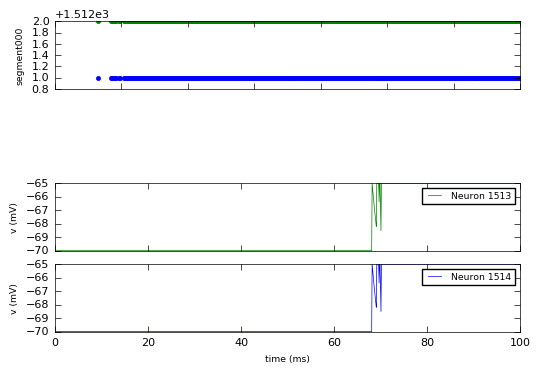

In [24]:
n_panels = sum(a.shape[1] for a in data_rout.segments[0].analogsignalarrays) + 2
plt.subplot(n_panels, 1, 1)
plot_spiketrains(data_rout.segments[0])
panel = 3
for array in data_rout.segments[0].analogsignalarrays:
    for i in range(array.shape[1]):
        plt.subplot(n_panels, 1, panel)
        plot_signal(array, i, colour='bg'[panel%2])
        panel += 1
plt.xlabel("time (%s)" % array.times.units._dimensionality.string)
plt.setp(plt.gca().get_xticklabels(), visible=True)

plt.savefig("neo_example.png")

Plot excitatory cells

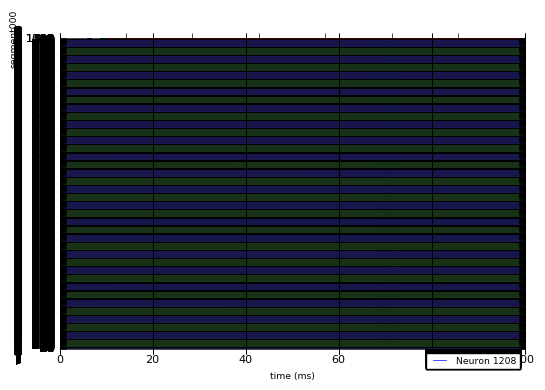

In [26]:
n_panels = sum(a.shape[1] for a in data_exc.segments[0].analogsignalarrays) + 2
plt.subplot(n_panels, 1, 1)
plot_spiketrains(data_exc.segments[0])
panel = 3
for array in data_exc.segments[0].analogsignalarrays:
    for i in range(array.shape[1]):
        plt.subplot(n_panels, 1, panel)
        plot_signal(array, i, colour='bg'[panel%2])
        panel += 1
plt.xlabel("time (%s)" % array.times.units._dimensionality.string)
plt.setp(plt.gca().get_xticklabels(), visible=True)

plt.savefig("neo_example.png")
